In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision import models
from torchvision.datasets import CIFAR10

from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from torchmetrics import Accuracy

from transformers import BertConfig, BertTokenizer, BertForSequenceClassification

import zipfile
import urllib.request
import os
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")

STANFORD_SNLI_URL = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
DATA_DIR = "data"

MAX_GRAD_NORM = 0.1

In [3]:
import pandas as pd
df = pd.read_csv("toxic_comments.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

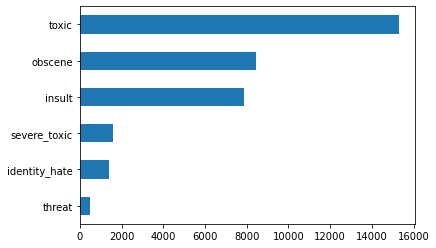

In [7]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

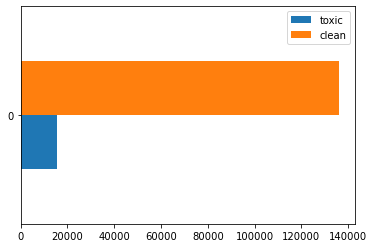

In [8]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [9]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((30382, 8), (7979, 8))

In [11]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
136533,da68c9213153ad77,"Upset \n\nI TRUSTED YOU!! IT TOOK ME LIKE, 15 ...",1,0,0,0,0,0
82504,dcb9537c47ee8ba7,"""\n\nLet's cut the bullshit, mmmkay? You are ...",1,0,1,0,0,0
78017,d0dd43e5382732fb,Hey \n\nHey guess what. Not that I told anyon...,1,0,1,0,0,0
10406,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1,0,1,0,1,0
75486,c9ecb93f83a794ae,"Hello, Anne. \n\nYou always were a bitch.",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
142853,fc013fd96a9408cb,"Awesome! \n\nHi, \n\nJust wanted to state that...",0,0,0,0,0,0
17566,2e710f36659e2ac6,"plus, you barely know anything about airliners...",0,0,0,0,0,0
64,00280c0d0652b366,"""\n\n DH \nDude, ABC officially says THIS is t...",0,0,0,0,0,0
142378,f9969dc36425e53a,""":::If you do a family tree starting with a th...",0,0,0,0,0,0


In [2]:
model_name = "bert-base-cased"
config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,
)
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-cased",
    do_lower_case=False,
)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    config=config,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [10]:
trainable_layers = [model.bert.encoder.layer[-1], model.bert.pooler, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~108M
print(f"Trainable parameters count: {trainable_params}") # ~7M

Total parameters count: 108312579
Trainable parameters count: 7680771


In [ ]:
LABEL_LIST = ['contradiction', 'entailment', 'neutral']
MAX_SEQ_LENGHT = 128

import torch
import transformers
from torch.utils.data import TensorDataset
from transformers.data.processors.utils import InputExample
from transformers.data.processors.glue import glue_convert_examples_to_features


def _create_examples(df, set_type):
    """ Convert raw dataframe to a list of InputExample. Filter malformed examples
    """
    examples = []
    for index, row in df.iterrows():
        if row['gold_label'] not in LABEL_LIST:
            continue
        if not isinstance(row['sentence1'], str) or not isinstance(row['sentence2'], str):
            continue
            
        guid = f"{index}-{set_type}"
        examples.append(
            InputExample(guid=guid, text_a=row['sentence1'], text_b=row['sentence2'], label=row['gold_label']))
    return examples

def _df_to_features(df, set_type):
    """ Pre-process text. This method will:
    1) tokenize inputs
    2) cut or pad each sequence to MAX_SEQ_LENGHT
    3) convert tokens into ids
    
    The output will contain:
    `input_ids` - padded token ids sequence
    `attention mask` - mask indicating padded tokens
    `token_type_ids` - mask indicating the split between premise and hypothesis
    `label` - label
    """
    examples = _create_examples(df, set_type)
    
    #backward compatibility with older transformers versions
    legacy_kwards = {}
    from packaging import version
    if version.parse(transformers.__version__) < version.parse("2.9.0"):
        legacy_kwards = {
            "pad_on_left": False,
            "pad_token": tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            "pad_token_segment_id": 0,
        }
    
    return glue_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        label_list=LABEL_LIST,
        max_length=MAX_SEQ_LENGHT,
        output_mode="classification",
        **legacy_kwards,
    )

def _features_to_dataset(features):
    """ Convert features from `_df_to_features` into a single dataset
    """
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
    all_token_type_ids = torch.tensor(
        [f.token_type_ids for f in features], dtype=torch.long
    )
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_token_type_ids, all_labels
    )

    return dataset

train_features = _df_to_features(df_train, "train")
test_features = _df_to_features(df_test, "test")

train_dataset = _features_to_dataset(train_features)
test_dataset = _features_to_dataset(test_features)

In [ ]:
BATCH_SIZE = 32
MAX_PHYSICAL_BATCH_SIZE = 8

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

In [ ]:
# Move the model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to train mode (HuggingFace models load in eval mode)
model = model.train()
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

In [ ]:
EPOCHS = 3
LOGGING_INTERVAL = 5000 # once every how many steps we run evaluation cycle and report metrics
EPSILON = 7.5
DELTA = 1 / len(train_dataloader) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

In [ ]:
from tqdm.notebook import tqdm

def accuracy(preds, labels):
    return (preds == labels).mean()

# define evaluation cycle
def evaluate(model):    
    model.eval()

    loss_arr = []
    accuracy_arr = []
    
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}

            outputs = model(**inputs)
            loss, logits = outputs[:2]
            
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = inputs['labels'].detach().cpu().numpy()
            
            loss_arr.append(loss.item())
            accuracy_arr.append(accuracy(preds, labels))
    
    model.train()
    return np.mean(loss_arr), np.mean(accuracy_arr)

In [ ]:
MAX_GRAD_NORM = 0.1

privacy_engine = PrivacyEngine()

model, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    target_delta=DELTA,
    target_epsilon=EPSILON, 
    epochs=EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
)

In [ ]:
from opacus.utils.batch_memory_manager import BatchMemoryManager

for epoch in range(1, EPOCHS+1):
    losses = []

    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for step, batch in enumerate(tqdm(memory_safe_data_loader)):
            optimizer.zero_grad()

            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]}

            outputs = model(**inputs) # output = loss, logits, hidden_states, attentions

            loss = outputs[0]
            loss.backward()
            losses.append(loss.item())

            optimizer.step()

            if step > 0 and step % LOGGING_INTERVAL == 0:
                train_loss = np.mean(losses)
                eps = privacy_engine.get_epsilon(DELTA)

                eval_loss, eval_accuracy = evaluate(model)

                print(
                  f"Epoch: {epoch} | "
                  f"Step: {step} | "
                  f"Train loss: {train_loss:.3f} | "
                  f"Eval loss: {eval_loss:.3f} | "
                  f"Eval accuracy: {eval_accuracy:.3f} | "
                  f"ɛ: {eps:.2f}"
                )

ModuleNotFoundError: ignored